In [1]:
import BasicMF
import NMF
import DatasetGen
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse
import pandas as pd
from sklearn.model_selection import train_test_split, KFold

## Préparation du Dataset

In [2]:
rating = pd.read_csv(r'data\ml-latest-small\ratings.csv')

# Réindexation des id des films pour avoir des ids contigues
movieid = rating['movieId'].unique()
movie_index = {id:k for k, id in enumerate(movieid)}

rating['movieId'] = rating['movieId'].apply(lambda x: movie_index[x])
rating['userId'] -= 1

In [16]:
X = rating[['movieId', 'userId']].values
y = rating['rating'].values

print('X')
print(X)
print('y')
print(y)

X
[[   0    0]
 [   1    0]
 [   2    0]
 ...
 [3121  609]
 [1392  609]
 [2873  609]]
y
[4. 4. 4. ... 5. 5. 3.]


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

## Entrainement de l'algorithme

In [26]:
MF = BasicMF.BasicMF(k=5, l=0.001, m=0.001, max_iter=100, tol=500, solver='gd', learning_rate=1e-4)
#MF = NMF.NMF(k=3, max_iter=100, solver='em', n_steps=1)

In [27]:
%%time
MF.fit(X_train, y_train, shape=(9724, 610), val=(X_test, y_test))

Wall time: 48.7 s


BasicMF(k=5, l=0.001, learning_rate=0.0001, m=0.001, solver='gd', tol=500)

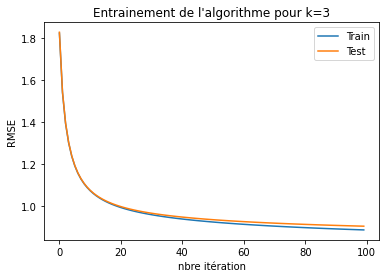

In [28]:
plt.plot(MF.history)
plt.title('Entrainement de l\'algorithme pour k='+str(3))
plt.ylabel('RMSE')
plt.xlabel('nbre itération')
plt.legend(('Train','Test'))

In [ ]:
#Estimation des performance à l'aide de cross-validation
kf = KFold(n_splits=4, random_state=None, shuffle=True)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    R_train, R_test = y[train_index], y[test_index]
    MF.fit(X_train, R_train, shape=(9724, 610))
    print(np.sqrt(((R_test - MF.predict(X_test))**2).sum()/R_test.size))

Résultats final sur l'ensemble de test

In [ ]:
np.sqrt(((R_test - MF.predict(X_test))**2).sum()/R_test.size)

In [ ]:
(np.abs(R_test - MF.predict(X_test)).sum()/R_test.size)

### PCA pour afficher les facteurs latents

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


I = MF.I

pca = PCA(n_components=2)
pca.fit(I)
#Visu_I = I
Visu_I = pca.transform(I)
plt.figure(figsize=(10,10))
plt.scatter(Visu_I[:, 0], Visu_I[:, 1], cmap='viridis', marker="o")
#print(pca.explained_variance_ratio_)
#print(pca.singular_values_)

### Recherche d'objet Similaire

In [ ]:
import scipy.spatial
import heapq

movie = pd.read_csv(r'data\ml-latest-small\movies.csv')
movie = movie.set_index('movieId')

U = MF.U
I = MF.I

top = []
for i in range(I.shape[0]):
    top.append([scipy.spatial.distance.cosine(I[movie_index[1258]],I[i]), movie.loc[movieid[i]]])
print(sorted(top,key=lambda x: x[0])[:30])#Les 30 film les plus proche

### Graphes pour les hyperparamètres de la factorisation classiques

In [ ]:
k_1 = [0.8921662650188509,
0.8888643207334456,
0.8827671973255237,
0.8953808776236044]

k_2 = [0.8695984882122897,
0.8783306764700133,
0.8739254029195798,
0.8685254044340959]

k_3 = [0.875646609183135,
0.8701150839861634,
0.8681791048733507,
0.8728040229415565]

k_4 = [0.8703069815879414,
0.877909826697152,
0.8750137811440928,
0.8721157770830615]

k_5 = [0.8761480680190616,
0.8684320743873634,
0.8721269854462634,
0.8668695385577445]

k_6 = [0.8740744694561137,
0.874500484031747,
0.8760333295114212,
0.8780100419556606]

k_7 = [0.8992813620539095,
0.8935027451592281,
0.8985000618072059,
0.8888889995275248]

K = np.array([k_1, k_2, k_3, k_4, k_5, k_6, k_7])
m =np.mean(K, axis=1)
err = 	2.32*np.std(K, axis=1)/np.sqrt(4)

plt.errorbar(np.arange(1, 9), np.mean(K, axis=1), yerr=err, ecolor='Black')

plt.xlabel('K')
plt.ylabel('RMSE')

## Interpretation de movie Lens  avec la NMF

In [65]:
MF = NMF.NMF(k=3, max_iter=100, solver='em', n_steps=1)
MF.fit(X, y, shape=(9724, 610))

NMF(k=3, solver='em')

<ipython-input-66-98939792b753>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(genresL, rotation=80)


[Text(0, 0, 'Action'),
 Text(1, 0, 'Adventure'),
 Text(2, 0, 'Animation'),
 Text(3, 0, 'Children'),
 Text(4, 0, 'Comedy'),
 Text(5, 0, 'Crime'),
 Text(6, 0, 'Documentary'),
 Text(7, 0, 'Drama'),
 Text(8, 0, 'Fantasy'),
 Text(9, 0, 'Film-Noir'),
 Text(10, 0, 'Horror'),
 Text(11, 0, 'IMAX'),
 Text(12, 0, 'Musical'),
 Text(13, 0, 'Mystery'),
 Text(14, 0, 'Romance'),
 Text(15, 0, 'Sci-Fi'),
 Text(16, 0, 'Thriller'),
 Text(17, 0, 'War'),
 Text(18, 0, 'Western'),
 Text(19, 0, 'no genres listed')]

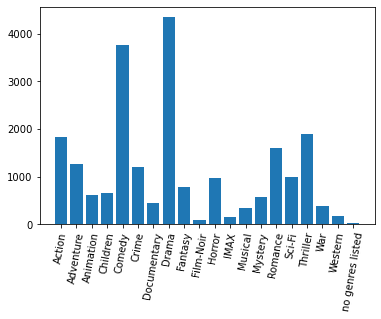

In [66]:
movies_info = pd.read_csv(r'data\ml-latest-small\movies.csv')
movies_info['movieId'] = movies_info['movieId'].apply(lambda x: movie_index[x] if x in movie_index else -1)
movies_info

# total of each genres in dataframe
movies_genresT = {}
for index, row in movies_info.iterrows():
    if row[0]!=-1:
        genres = row['genres'].replace('(','').replace(')','').split('|')
        for genre in genres:
            if genre in movies_genresT:
                movies_genresT[genre] += 1
            else:
                movies_genresT[genre]=1
genresL = list(movies_genresT.keys())
genresL.sort()
valuesG = [movies_genresT[key] for key in genresL]
fig, ax = plt.subplots()
ax.bar(genresL, valuesG)
ax.set_xticklabels(genresL, rotation=80)

In [67]:
U = MF.U
df = pd.DataFrame(U)
df

,0,1,2
0,0.342504,1.626361,1.391957
1,1.022441,0.094571,6.753269
2,0.767054,1.890177,1.210901
3,0.000000,0.000000,0.000000
4,1.603770,1.014189,0.955989
...,...,...,...
9719,0.000000,0.000000,0.000000
9720,0.000000,0.000000,0.000000
9721,0.000000,0.000000,0.000000
9722,0.000000,0.000000,0.000000


Group 1
Group 2
Group 3


<ipython-input-68-fd19b56f781b>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(genresL, rotation=80)
<ipython-input-68-fd19b56f781b>:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(datesL, rotation=60)


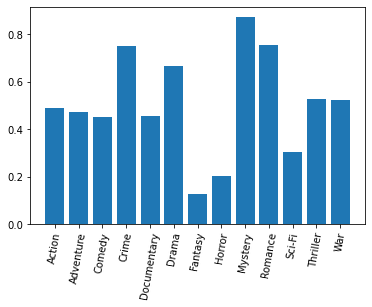

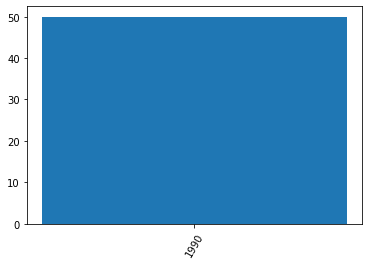

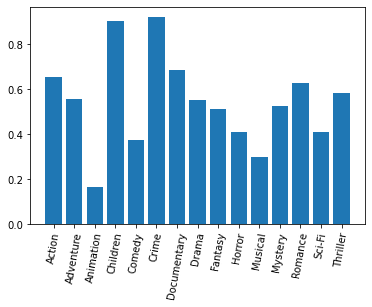

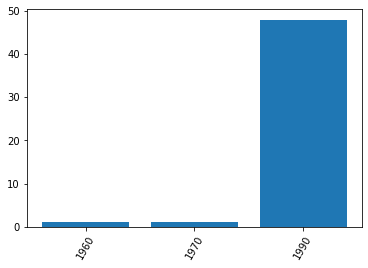

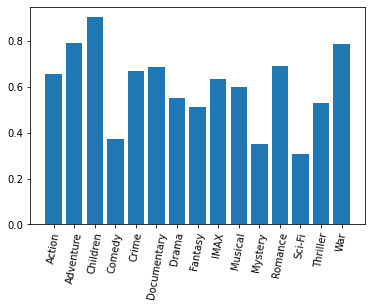

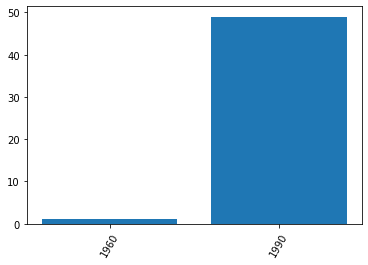

In [68]:
n_movies = 50 # nombre de films à prendre en compte pour chaque groupes

for j in range(U.shape[1]):
    print("Group " + str(j+1))
    movies_dates = {}
    movies_genres = {}
    df.sort_values(by=[j], ascending=False, inplace=True)
    v = df.index[0:n_movies]
    for k in range(n_movies):
        date = movies_info.iloc[v[k]].loc['title'].replace(')','').split('(')[-1][:-1]+'0'
        genres = movies_info.iloc[v[k]].loc['genres'].replace('(','').replace(')','').split('|')
        if date in movies_dates:
            movies_dates[date] += 1
        else:
            movies_dates[date]=1
        for genre in genres:
            if genre in movies_genres:
                movies_genres[genre] += 1
            else:
                movies_genres[genre]=1
    genresL = list(movies_genres.keys())
    genresL.sort()
    valuesG = [(movies_genres[key]*100)/movies_genresT[key] for key in genresL]
    
    fig, ax = plt.subplots()
    ax.bar(genresL, valuesG)
    ax.set_xticklabels(genresL, rotation=80)
    
    datesL = list(movies_dates.keys())
    datesL.sort()
    valuesD = [movies_dates[key] for key in datesL]
 
    fig, ax = plt.subplots()
    ax.bar(datesL, valuesD)
    ax.set_xticklabels(datesL, rotation=60)

## Dataset Synthétique

In [30]:
data = DatasetGen.DatasetGen(200, 50)
matrix = data.gen_dataset(5, 500)

c:\users\juju_2\appdata\local\programs\python\python38\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [32]:
l = matrix.tocoo()
X = np.dstack((l.row, l.col))[0]
y = l.data
del l

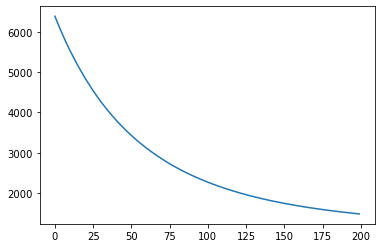

In [33]:
MF = BasicMF.BasicMF(k=5, l=0.001, m=0.001, max_iter=200, tol=1, solver='gd', learning_rate=1e-4)
MF.fit(X,y, shape=(200, 50))
plt.plot(MF.history)

[2 3 1 0 0 0 4 2 1 0 1 4 3 1 1 2 4 0 1 1 1 0 3 1 0 2 2 3 3 4 1 0 1 4 4 4 3
 4 0 1 2 3 4 3 2 1 0 1 3 2]


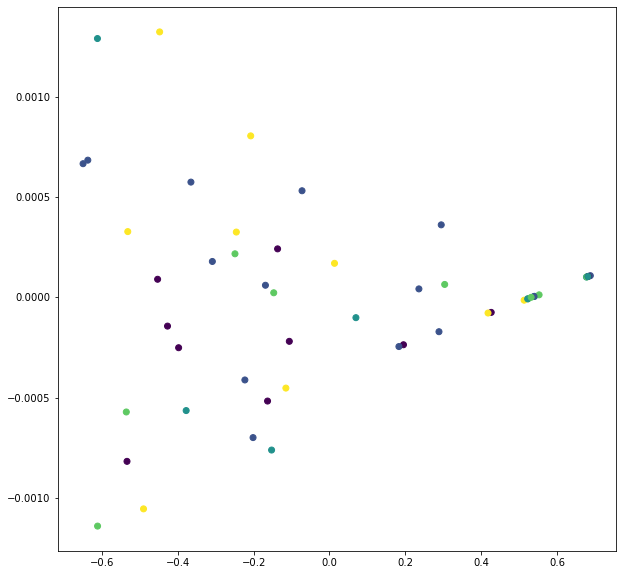

In [36]:
from sklearn.decomposition import PCA

U = MF.U
I = MF.I

pca = PCA(n_components=2)
pca.fit(U)
#Visu_I = I
Visu_U = pca.transform(U)

plt.figure(figsize=(10,10))
plt.scatter(Visu_U[:, 0], Visu_U[:, 1], c=data.user_grp, cmap='viridis', marker="o")
#plt.scatter(U[:,0], U[:,1],  c=test.user_grp, cmap='viridis')
print(data.user_grp)

In [38]:
#Affichage des lignes de la matrice U et de son groupe
for u in range(U.shape[0]):
    print(U[u], data.user_grp[u])

[0.94053759 0.94053759 0.94053759 0.94053759 0.94053745] 2
[0.58740255 0.58740255 0.58740255 0.58740258 0.58654354] 3
[0.56072337 0.56072337 0.56072337 0.56072333 0.55986028] 1
[0.45996694 0.45996694 0.45996694 0.45959367 0.45993628] 0
[0.50778925 0.50778925 0.50778925 0.50778931 0.5071941 ] 0
[0.52085571 0.52085571 0.52085571 0.52085571 0.52040423] 0
[0.4793013  0.4793013  0.4793013  0.47930129 0.47967686] 4
[0.52967854 0.52967854 0.52967854 0.52967853 0.52959365] 2
[0.8278364  0.8278364  0.8278364  0.82783648 0.82783559] 1
[0.78597353 0.78597353 0.78597353 0.78597353 0.7859719 ] 0
[0.66654133 0.66654133 0.66654133 0.66654126 0.66546939] 1
[0.46103177 0.46103177 0.46103177 0.46103171 0.45982638] 4
[0.83462102 0.83462102 0.83462102 0.83462102 0.83436814] 3
[0.59894556 0.59892845 0.59892845 0.59892844 0.59879849] 1
[0.4083972  0.4083972  0.4083972  0.40839721 0.40671994] 1
[0.42550034 0.42550034 0.42550034 0.42550034 0.4231541 ] 2
[0.70474997 0.70474997 0.70474997 0.70474993 0.70415063]

In [39]:
#NMF
MF = NMF.NMF(k=5, max_iter=25, solver='em', n_steps=1)

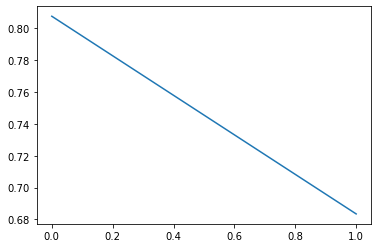

In [41]:
MF.fit(X,y, shape=(200, 50))
plt.plot(MF.history)

## finding groups with NMF

In [42]:
def showInnitGroup(l, n_groups):
    groups = [[] for k in range(n_groups)]
    for i,ele in enumerate(l):
        groups[ele].append(i)
    for k in range(n_groups):
        print('Group ' + str(k) + ' : ' + str(groups[k]))

In [43]:
def findGroups(V):
    groups = [[] for k in range(V.shape[0])]
    df = pd.DataFrame(V)
    for j in range(V.shape[1]):
        ind = df[j].argmax()
        #print(str(j)+'->'+str(ind))
        groups[ind].append(j)
    for k in range(V.shape[0]):
        print('Group ' + str(k) + ' : ' + str(groups[k]))

In [44]:
def valuesTM(M):
    X=[]
    y=[]
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            if M[i,j]!=0:
                X.append([i,j])
                y.append(M[i,j])
    return X,y

In [46]:
def randomMatrixInnit(shape):
    a = np.ones(shape) - np.random.rand(shape[0],shape[1])
    return a

In [49]:
U = randomMatrixInnit((200,5))*2
V = randomMatrixInnit((5,50))*2

Xm, ym = valuesTM(matrix)

MF = NMF.NMF(k=5, max_iter=100, solver='em', n_steps=5)
MF.fit(np.array(Xm), np.array(ym), shape=(200, 50))

NMF(k=5, n_steps=5, solver='em')

In [57]:
showInnitGroup(data.user_grp,5)

Group 0 : [3, 4, 5, 9, 17, 21, 24, 31, 38, 46]
Group 1 : [2, 8, 10, 13, 14, 18, 19, 20, 23, 30, 32, 39, 45, 47]
Group 2 : [0, 7, 15, 25, 26, 40, 44, 49]
Group 3 : [1, 12, 22, 27, 28, 36, 41, 43, 48]
Group 4 : [6, 11, 16, 29, 33, 34, 35, 37, 42]


In [56]:
findGroups(MF.V.T)

Group 0 : [5, 7, 12, 17, 21, 25, 38]
Group 1 : [0, 3, 8, 11, 14, 22, 30, 32, 37, 40, 42, 49]
Group 2 : [1, 2, 6, 9, 13, 15, 16, 18, 19, 20, 23, 24, 28, 33, 35, 36, 41]
Group 3 : [4, 29]
Group 4 : [10, 26, 27, 31, 34, 39, 43, 44, 45, 46, 47, 48]


<ipython-input-43-88d6452ee8dd>:5: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  ind = df[j].argmax()
